# Assignment 3

## Filepaths & Variable Declarations

In [1]:
GPA_GRE_FILE = './data/gpa-gre.csv'
DWELL_TIMES_FILE = './data/multiple-sites.tsv'

## Imports

In [2]:
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, col

## Function declarations and setup

In [3]:
sns.set()
DPI = 200

def plot_large():
    plt.figure(figsize=(8,5), dpi=DPI)

## Problem 1: GPA-GRE Regression with SciKit

### Reading dataset into pandas DataFrame
We'll just drop rows which have missing data using `df.dropna()`.

In [4]:
df = pd.read_csv(GPA_GRE_FILE)
df['Combined'] = df['Verbal'] + df['Quant']
df = df.dropna(subset=['Combined'])
df.head()

,Year,GPA,Verbal,Quant,Combined
0,1,4.00,420.0,800.0,1220.0
1,1,3.88,480.0,770.0,1250.0
2,1,3.88,480.0,780.0,1260.0
3,1,3.87,440.0,690.0,1130.0
4,1,3.85,320.0,800.0,1120.0


### Splitting into training and test sets

In [5]:
X = df['Combined'].values.reshape(-1, 1)
y = df['GPA']
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.15)

### a) Linear Regression Model

In [6]:
linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X_train, y_train);

We have to use `np.hstack()` since X_train is a 2D array and we have to convert it into a single, contiguous array.

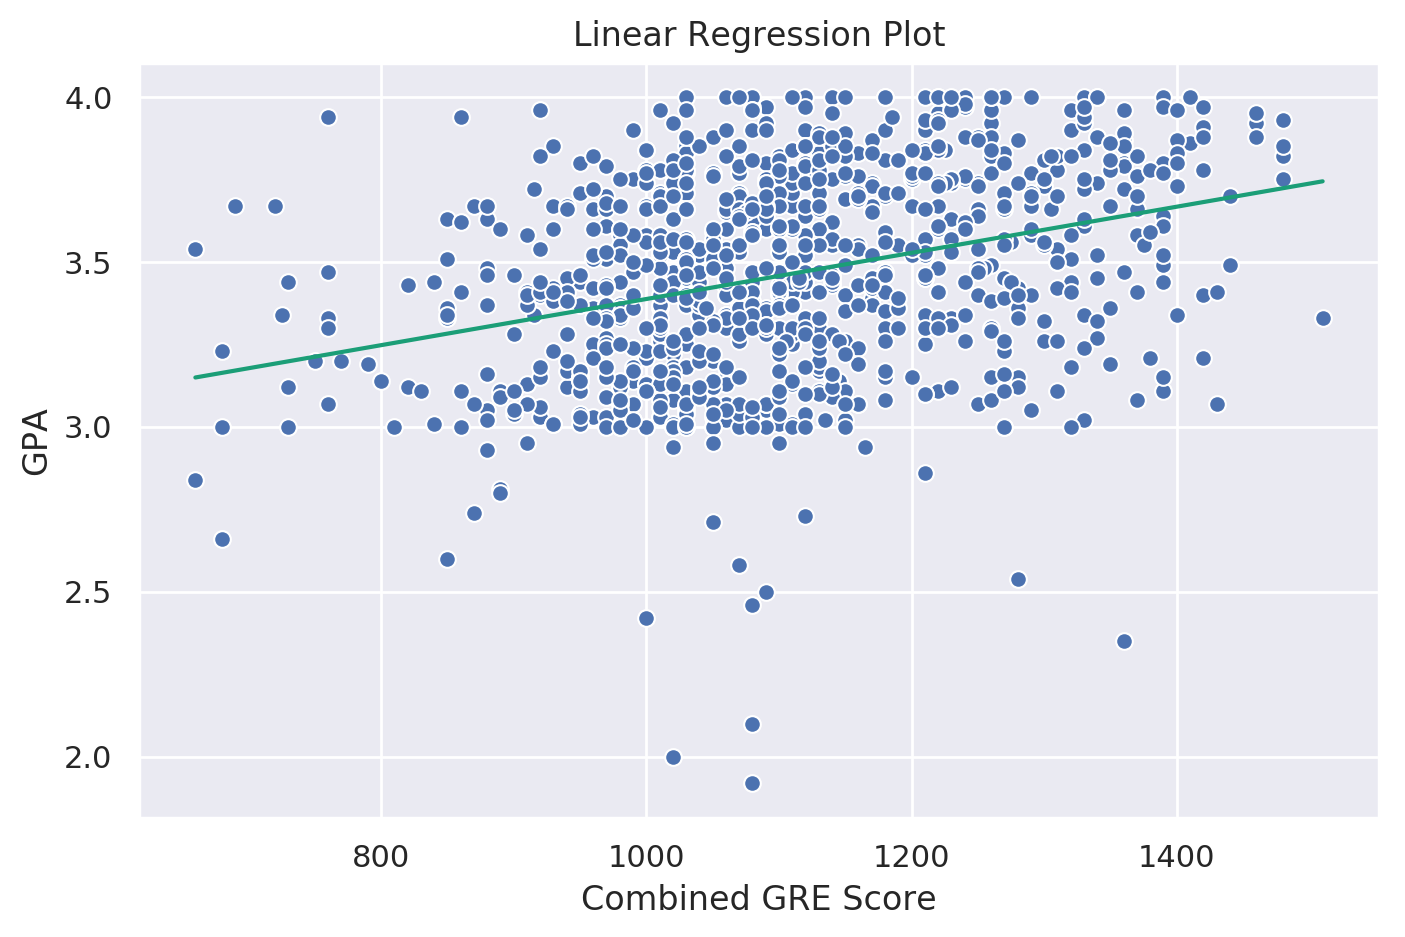

In [7]:
plot_large()
sns.scatterplot(x=np.hstack(X_train), y=y_train)
sns.lineplot(x=np.hstack(X_train), y=linear_model.predict(X_train), color="#1b9e77")
plt.xlabel('Combined GRE Score')
plt.ylabel('GPA')
plt.title('Linear Regression Plot');

### b) R2 Score

In [8]:
y_pred = linear_model.predict(X_test)
sklearn.metrics.r2_score(y_test, y_pred)

-0.03562952398649433

### c) Residuals Plot

In [9]:
residuals = y_test - y_pred
print("Sum of residuals: {}".format(residuals.sum()))
print("Mean of residuals: {}".format(residuals.mean()))

Sum of residuals: -6.102316509732601
Mean of residuals: -0.037668620430448156


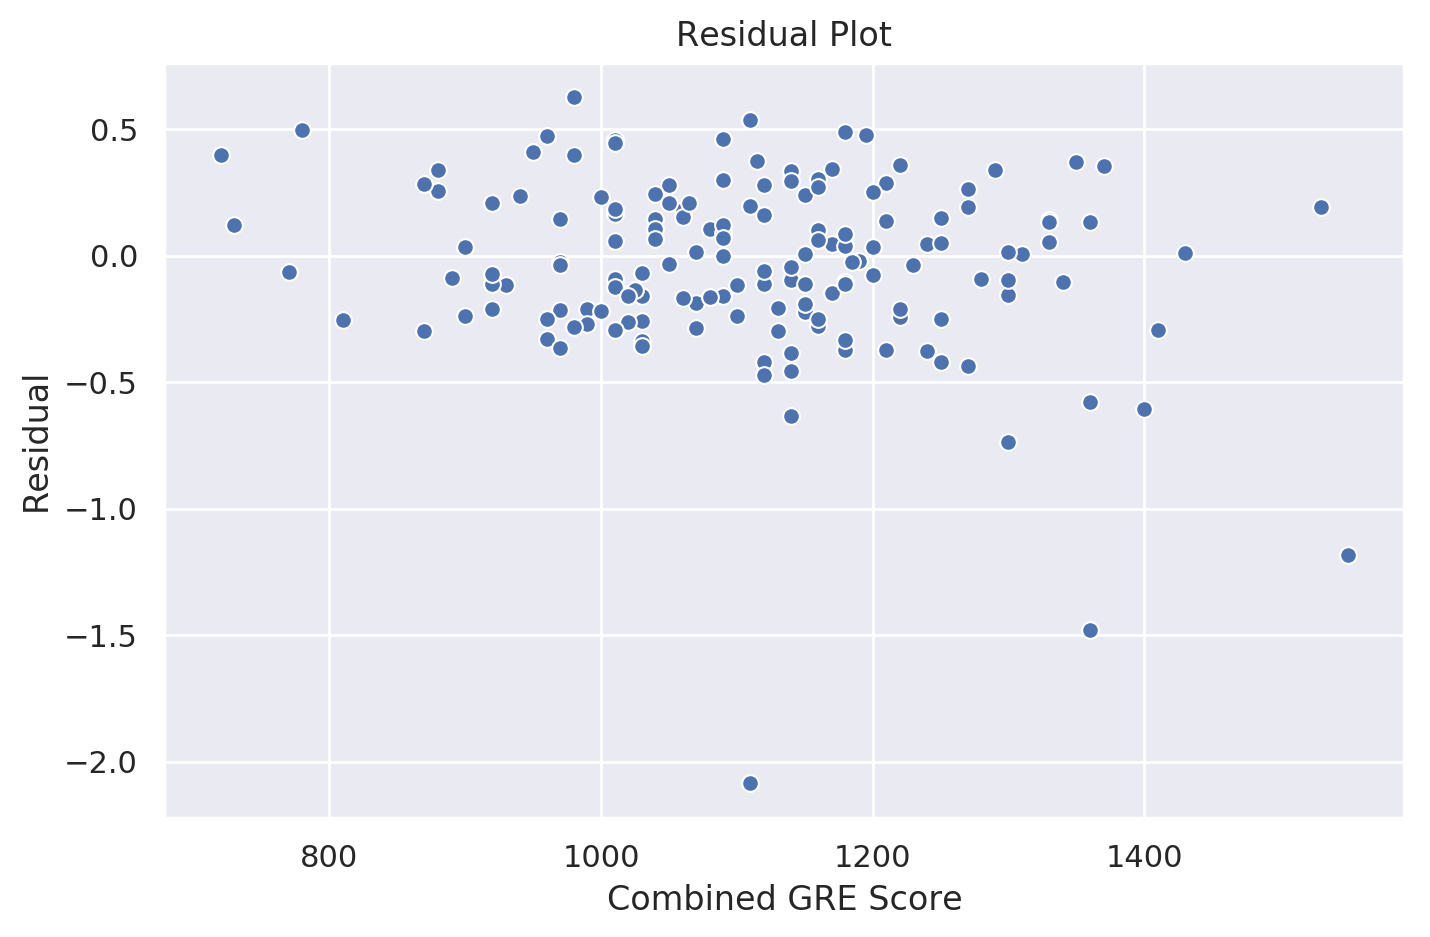

In [10]:
plot_large()
sns.scatterplot(x=np.hstack(X_test), y=residuals)
plt.xlabel('Combined GRE Score')
plt.ylabel('Residual')
plt.title('Residual Plot');

### Comments
A Linear Regression model does not fit the data well. There are 3 factors behind this conclusion:
1. The visualization shows how the calculated line does not cover all the data, which is very spread out
1. The R2 score is low, which tells us that the model's predictions capture only a small amount of the variance of the real values
1. The sum of residuals is not 0 and that means the residuals aren't randomly distributed

The above indicators help us conclude that the Linear Regression is not a good model for this data.

## Problem 2: Dwell Times

### Using SciKit

#### Reading dataset into a pandas DataFrame

In [11]:
pandas_df = pd.read_csv(DWELL_TIMES_FILE, delimiter='\t')
pandas_df.head()

,site,dwell-time
0,13,28
1,6,33
2,17,81
3,1,67
4,16,87


#### Calculating Mean and Standard Deviation
We can use SciKit's StandardScaler to compute the mean and standard deviation of the dwell times. The `astype('float64')` call is to remove sklearn.exceptions.DataConversionWarning in StandardScaler.

In [14]:
site_list = sorted(pandas_df['site'].unique())

site_mean = pandas_df.groupby(['site']).mean().reset_index()['dwell-time'].values
site_std = pandas_df.groupby(['site']).std().reset_index()['dwell-time'].values

times_dict = {'Site': site_list, 'Mean': site_mean, 'Standard Deviation': site_std}
times_df = pd.DataFrame.from_dict(times_dict)
times_df.head(20)

,Site,Mean,Standard Deviation
0,0,79.851064,79.135266
1,1,106.000000,103.790126
2,2,88.229167,88.709001
3,3,97.479167,74.814093
4,4,94.333333,77.725843
5,5,102.333333,87.700618
6,6,144.192982,146.930917
7,7,123.367347,117.025584
8,8,94.346939,97.564626
9,9,89.820000,100.470463


#### Plotting Mean and Standard Deviation

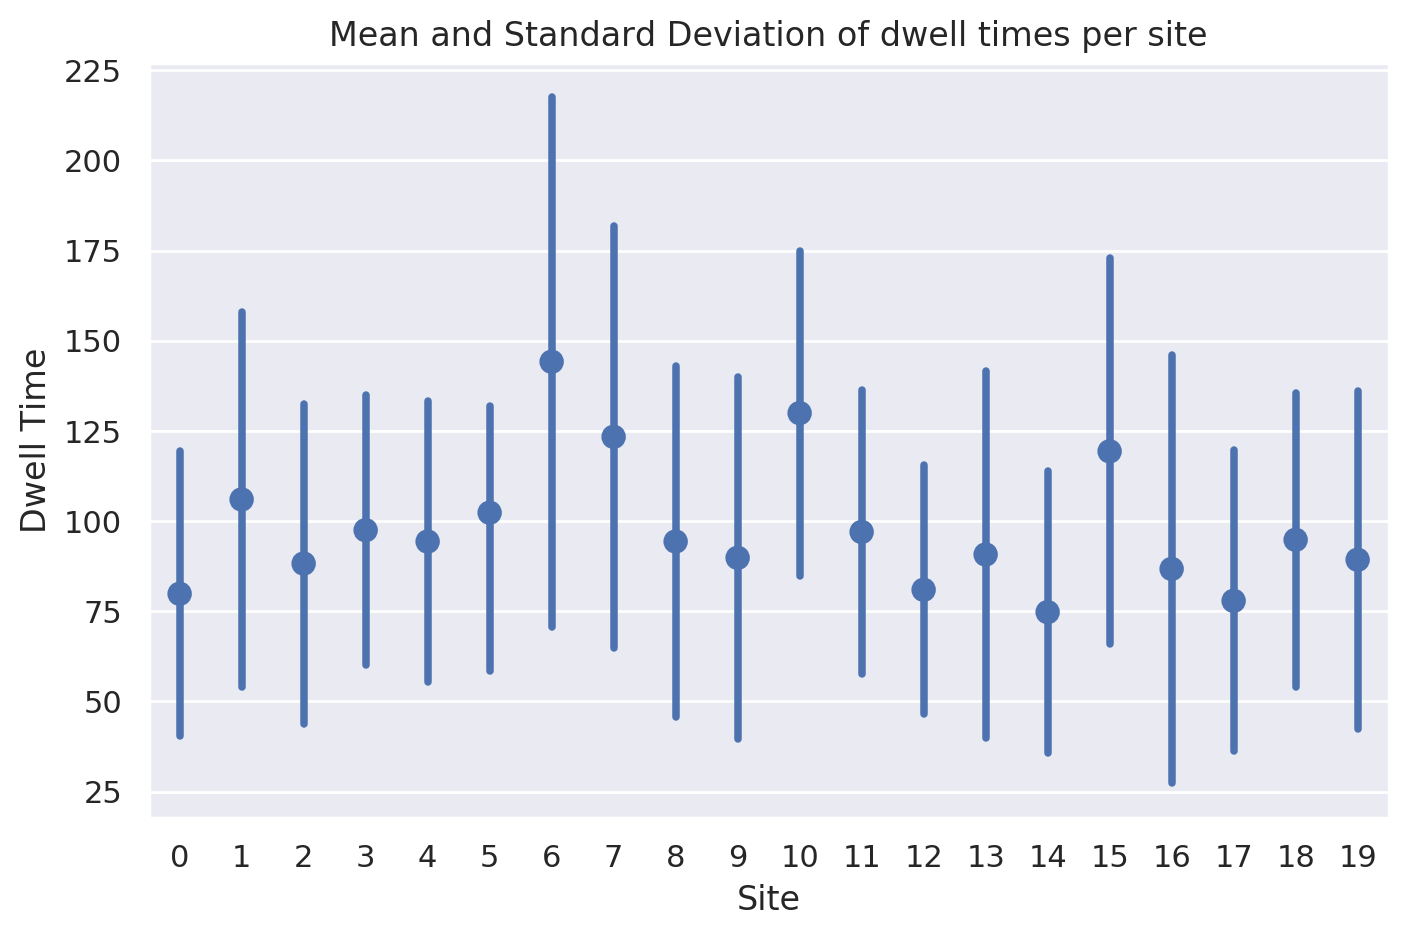

In [15]:
plot_dict = {'dwell-time': (site_mean - site_std/2, site_mean, site_mean + site_std/2)}
plot_df = pd.DataFrame(data=[site_mean - site_std/2, site_mean, site_mean + site_std/2])

plot_large()
sns.pointplot(data=plot_df, join=False)
plt.xlabel('Site')
plt.ylabel('Dwell Time')
plt.title('Mean and Standard Deviation of dwell times per site');

### Using Spark

#### Reading Dataset into Spark DataFrame

In [16]:
reader = spark.read
reader.option("header", True)
reader.option("inferSchema", True)
reader.option("delimiter", "\t")
spark_df = reader.csv(DWELL_TIMES_FILE)
spark_df.show()

+----+----------+
|site|dwell-time|
+----+----------+
|  13|        28|
|   6|        33|
|  17|        81|
|   1|        67|
|  16|        87|
|   2|        56|
|   2|        72|
|   6|       297|
|  13|         2|
|   1|        94|
|   5|       210|
|   4|        49|
|   8|       152|
|   2|        31|
|   5|       146|
|  10|       226|
|   9|       152|
|   1|         7|
|  12|        17|
|  10|       105|
+----+----------+
only showing top 20 rows



#### Calculating Mean and Standard Deviation

In [17]:
spark_plan = spark_df.orderBy('site').groupBy('site').agg(
                        mean(col('dwell-time')).alias('mean'),
                        stddev(col('dwell-time')).alias('std'))
spark_plan.show()

+----+------------------+------------------+
|site|              mean|               std|
+----+------------------+------------------+
|   0| 79.85106382978724| 79.13526634363751|
|   1|             106.0|103.79012594607659|
|   2| 88.22916666666667| 88.70900061876551|
|   3| 97.47916666666667|  74.8140928763278|
|   4| 94.33333333333333| 77.72584297816697|
|   5|102.33333333333333|  87.7006178654617|
|   6|144.19298245614036|146.93091654103628|
|   7|123.36734693877551|117.02558371953526|
|   8| 94.34693877551021| 97.56462623572646|
|   9|             89.82|100.47046271193848|
|  10|129.95238095238096| 90.10940569215181|
|  11| 96.98214285714286| 78.94635487501591|
|  12| 80.95081967213115| 68.98729985282513|
|  13| 90.73770491803279|102.01387187360751|
|  14| 74.76470588235294| 78.26278508596386|
|  15|119.34782608695652|107.02050009046641|
|  16| 86.74418604651163|118.83523868570455|
|  17|  77.8913043478261| 83.41388860132467|
|  18| 94.81481481481481| 81.65760870487834|
|  19| 89.

#### Plotting Mean and Standard Deviation

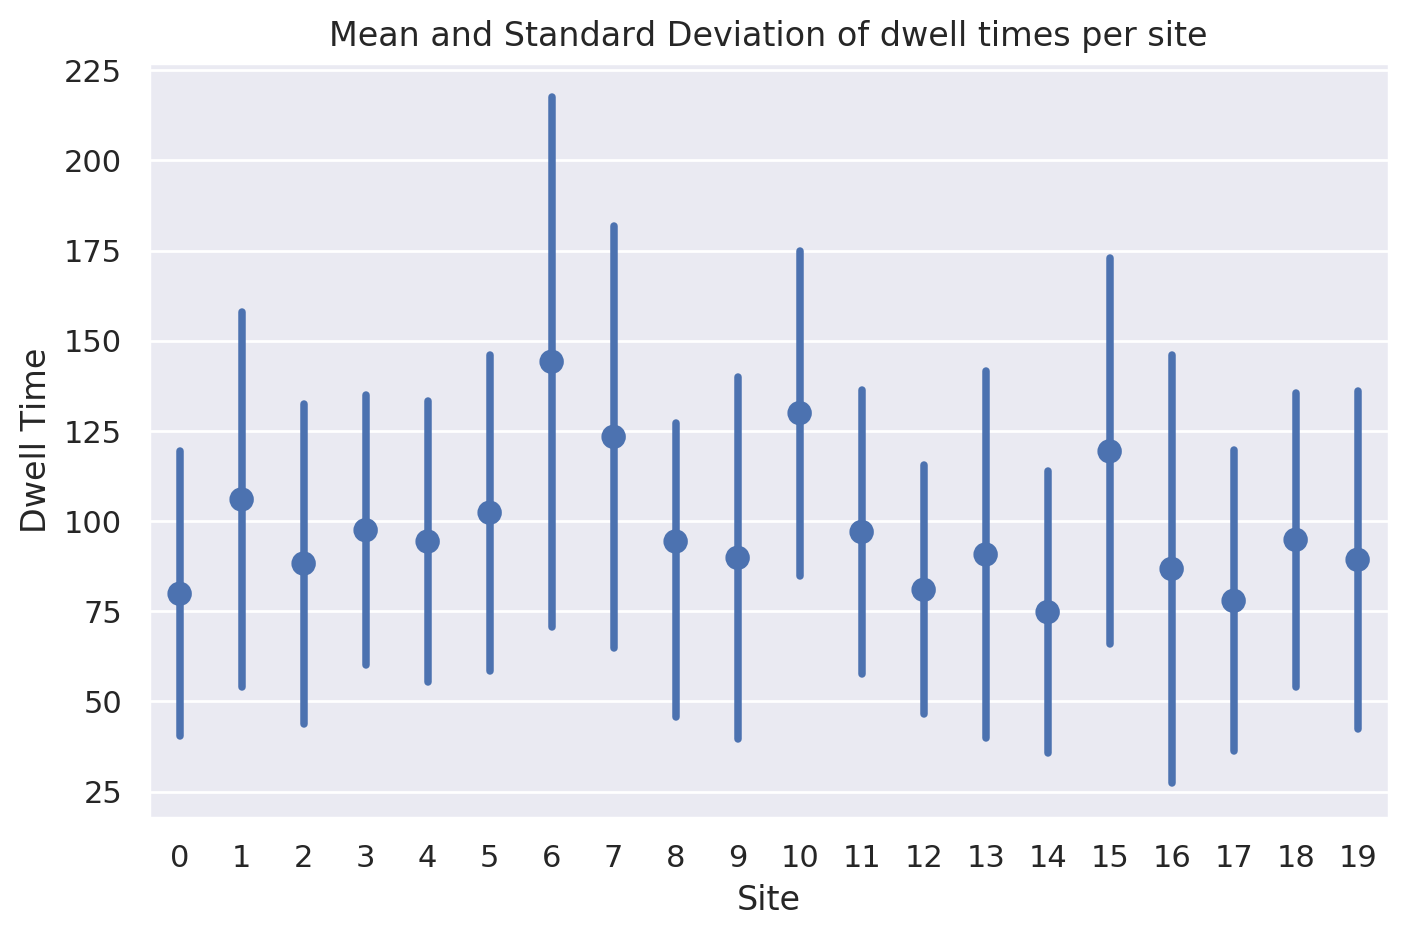

In [18]:
times_dict = {}
for row in spark_plan.collect():
    site_mean = row['mean']
    site_std = row['std']
    times_dict[row['site']] = [site_mean - site_std/2, site_mean, site_mean + site_std/2]

times_df = pd.DataFrame.from_dict(times_dict)
plot_large()
sns.pointplot(data=times_df, join=False)
plt.xlabel('Site')
plt.ylabel('Dwell Time')
plt.title('Mean and Standard Deviation of dwell times per site');

### Comments
The standard deviation values are slightly different due to the difference in how it is calculated by the 2 libraries. StandardScaler uses `np.std()`.